#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"



Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import glob
import re
import pandas
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

## Importación de librerías necesarias para el notebook

Ejemplo de salida de una imágen luego de aplicada la transformación Adaptativa

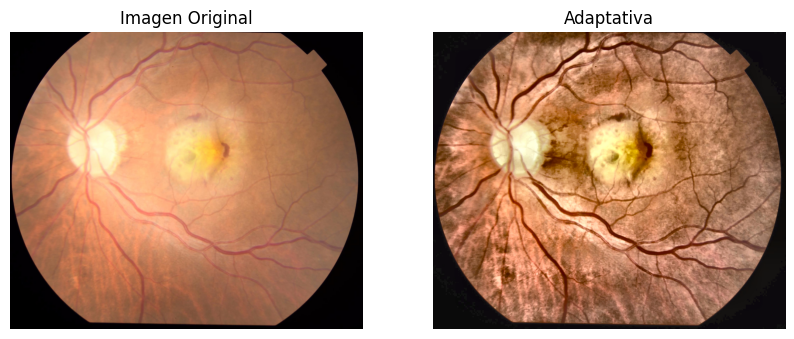

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
l_channel, a_channel, b_channel = cv2.split(lab_image)
l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)
l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)
lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))
image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)

# Mostrar la imagen original y la imagen con transf. adaptativa
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Adaptativa')
plt.imshow(cv2.cvtColor(image_eq, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Función para convertir la imágen aplicando el filtro Adaptativa.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

def preprocessing_image(image):

    # Convertir la imagen de BGR a LAB
    # Comprobar si la imagen es de tipo float y escalar a 0-255 si es necesario
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    # Convertir la imagen de RGB a LAB
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Separar los canales LAB
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Aplicar ecualización adaptativa del histograma al canal L
    l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)

    # Convertir el canal L ecualizado de float64 a uint8
    l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)

    # Combinar los canales LAB con el canal L ecualizado
    lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))

    # Convertir la imagen de LAB de vuelta a RGB
    image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)

    # Redimensionar la imagen al tamaño esperado por el modelo
    image_eq_resized = cv2.resize(image_eq, (224,224))

    # Preprocesar la imagen para ResNet50V2
    image_eq_preprocessed = preprocess_input(image_eq_resized.astype(np.float32))

    return image_eq_preprocessed


## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(15,15))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(15,15))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
base_model1 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model1.layers:
    layer.trainable = False


model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 774       
                                                                 
Total params: 23827846 (90.90 MB)
Trainable params: 263046 (1.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

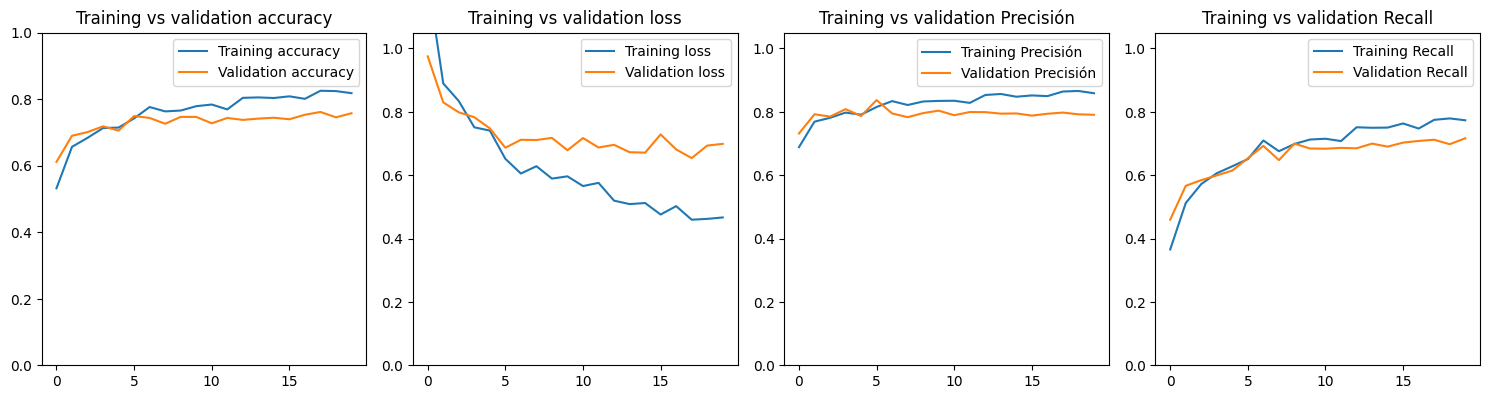

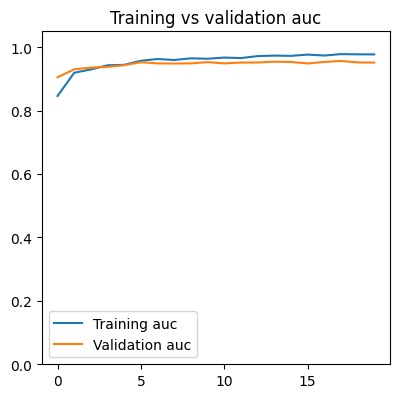

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 19s 502ms/step


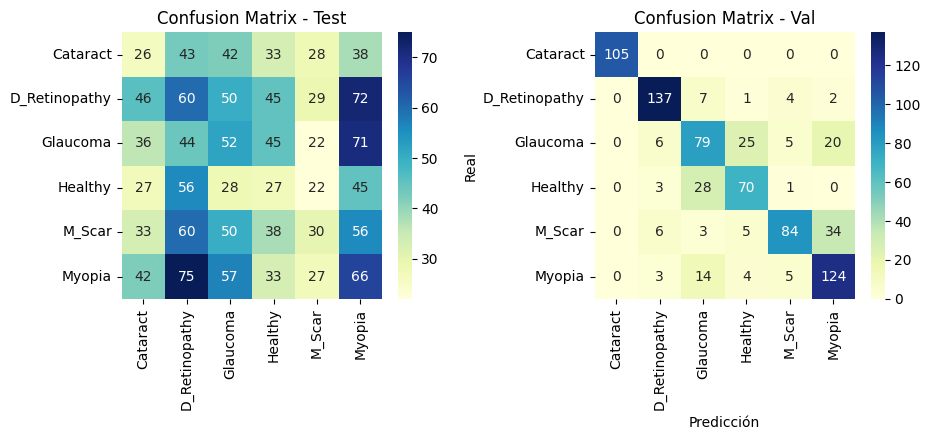

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.18      0.20      0.19       302
           2       0.19      0.19      0.19       270
           3       0.12      0.13      0.13       205
           4       0.19      0.11      0.14       267
           5       0.19      0.22      0.20       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.88      0.91      0.90       151
           2       0.60      0.59      0.59       135
           3       0.67      0.69      0.68       102
           4       0.85      0.64      0.73       132
           5       0.69      0.83      0.75       150

    accuracy                           0.77       775
   macro avg       0.78

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

94668760/94668760 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 24123014 (92.02 MB)
Trainable params: 55821

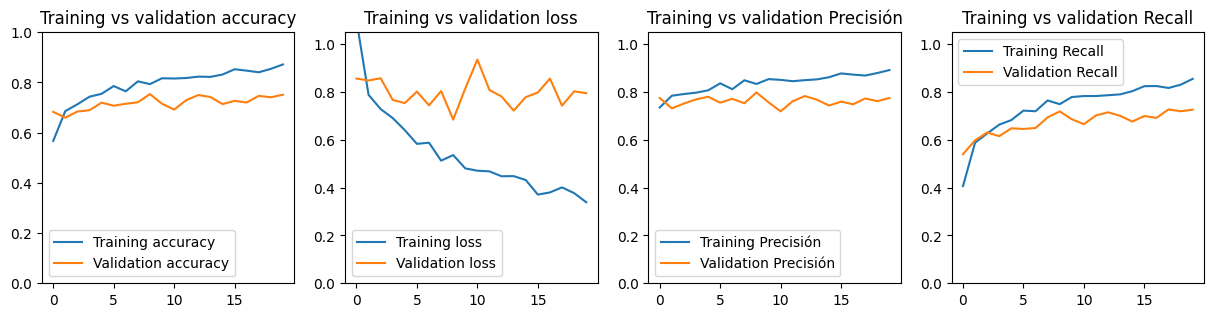

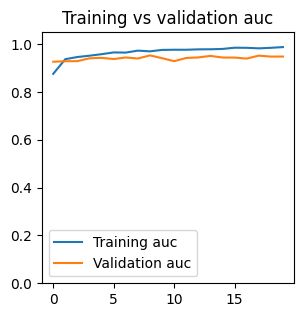

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 23s 593ms/step


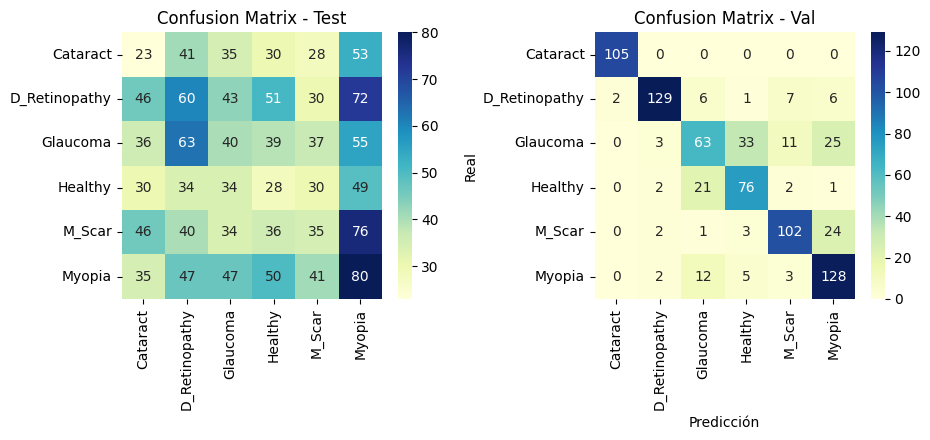

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.11      0.11       210
           1       0.21      0.20      0.20       302
           2       0.17      0.15      0.16       270
           3       0.12      0.14      0.13       205
           4       0.17      0.13      0.15       267
           5       0.21      0.27      0.23       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.93      0.85      0.89       151
           2       0.61      0.47      0.53       135
           3       0.64      0.75      0.69       102
           4       0.82      0.77      0.79       132
           5       0.70      0.85      0.77       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 5

In [ ]:
base_model5 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model5.layers:
    layer.trainable = False


model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_6 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                      

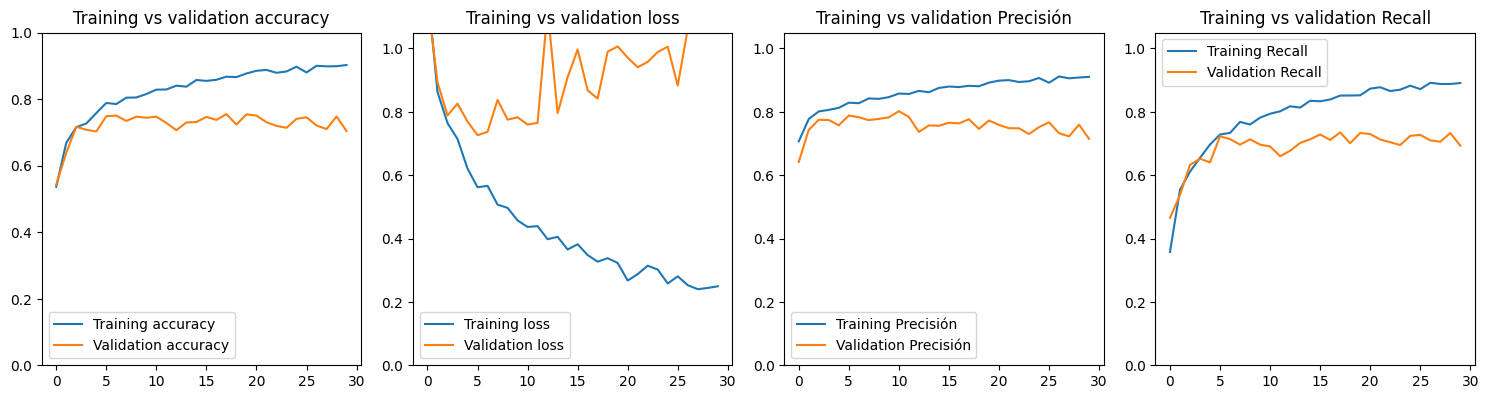

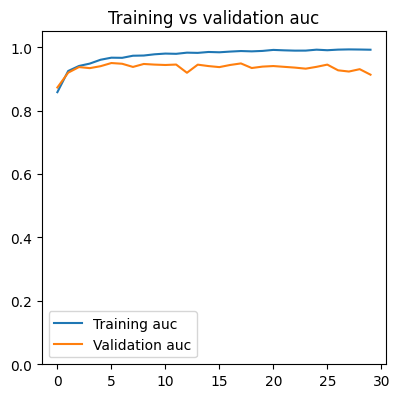

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 20s 513ms/step


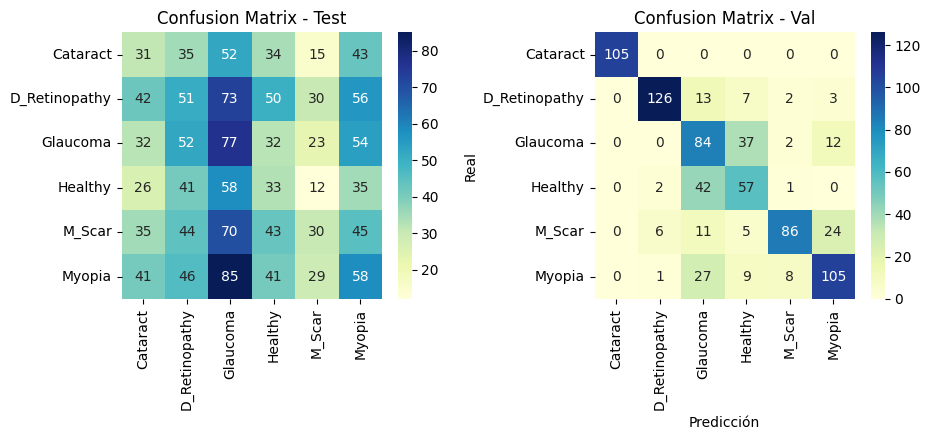

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.19      0.17      0.18       302
           2       0.19      0.29      0.22       270
           3       0.14      0.16      0.15       205
           4       0.22      0.11      0.15       267
           5       0.20      0.19      0.20       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.93      0.83      0.88       151
           2       0.47      0.62      0.54       135
           3       0.50      0.56      0.53       102
           4       0.87      0.65      0.74       132
           5       0.73      0.70      0.71       150

    accuracy                           0.73       775
   macro avg       0.75

## Modelo 15

In [ ]:
base_model15 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model15.layers:
    layer.trainable = False


model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 2056)              4212744   
                                                                 
 dense_11 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                      

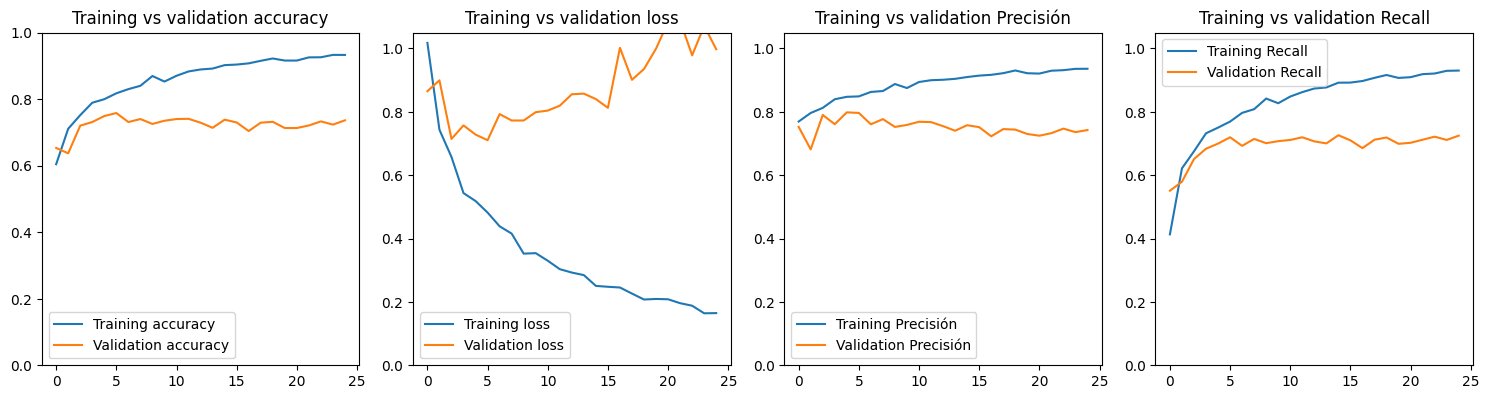

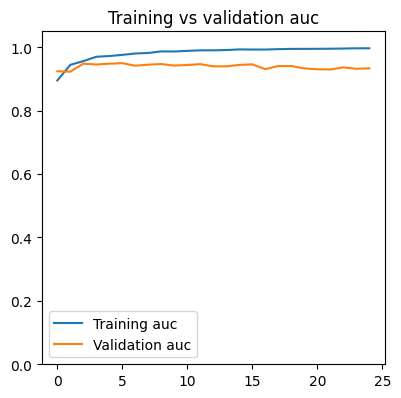

In [ ]:
graph(history15)

39/39 [==============================] - 19s 502ms/step


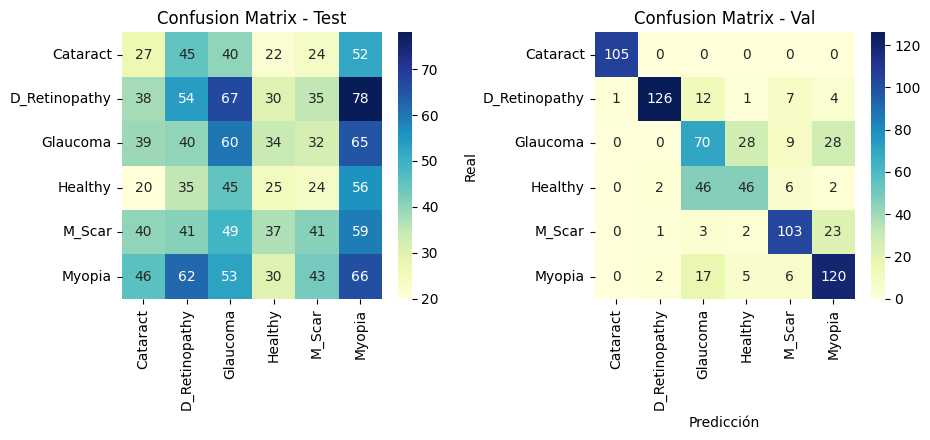

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.18      0.19       302
           2       0.19      0.22      0.21       270
           3       0.14      0.12      0.13       205
           4       0.21      0.15      0.18       267
           5       0.18      0.22      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.96      0.83      0.89       151
           2       0.47      0.52      0.49       135
           3       0.56      0.45      0.50       102
           4       0.79      0.78      0.78       132
           5       0.68      0.80      0.73       150

    accuracy                           0.74       775
   macro avg       0.74

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 2056)              4212744   
                                                                 
 dropout_1 (Dropout)         (None, 2056)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                      

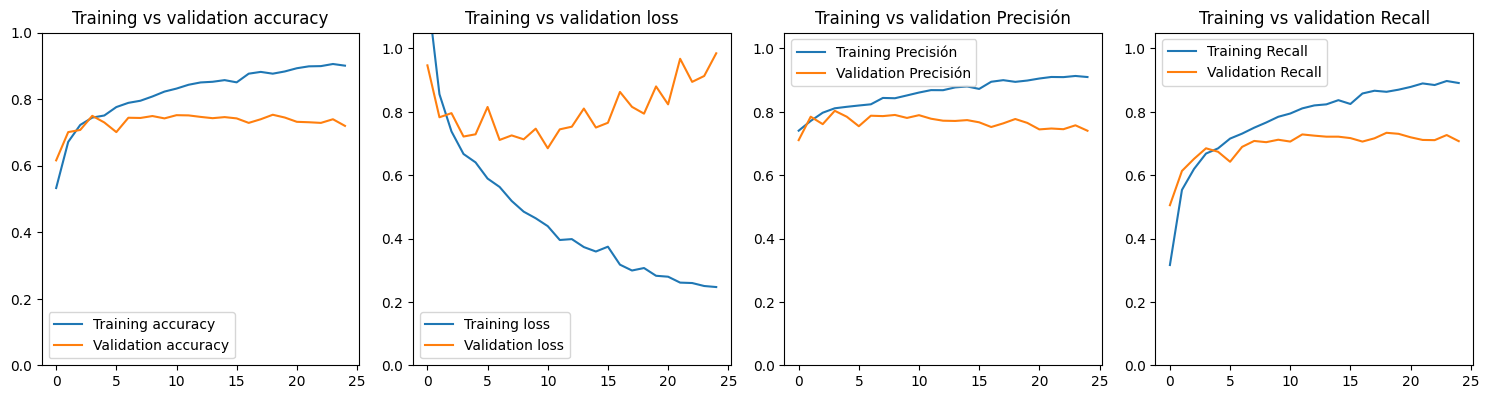

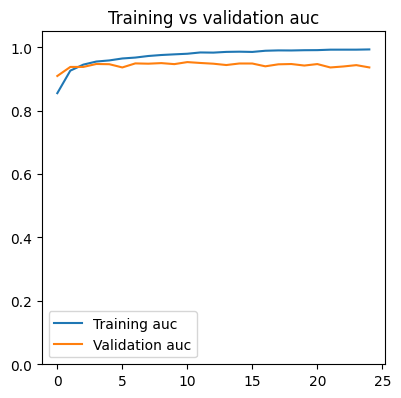

In [ ]:
graph(history16)

39/39 [==============================] - 20s 521ms/step


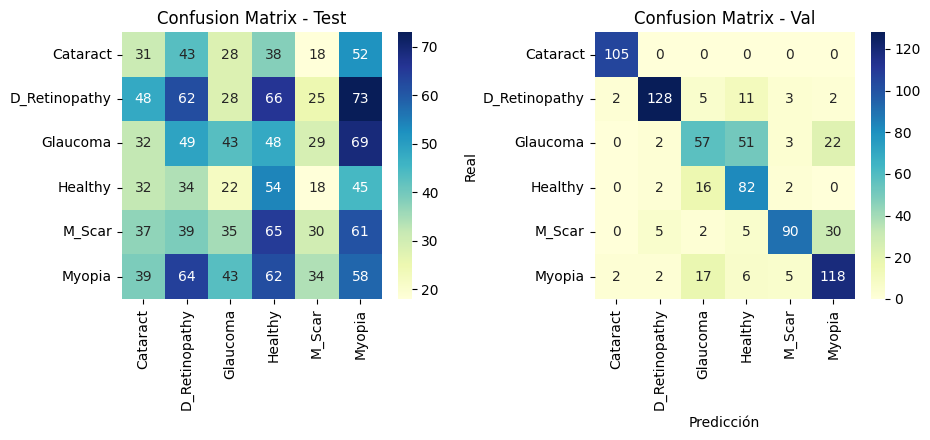

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.15      0.14       210
           1       0.21      0.21      0.21       302
           2       0.22      0.16      0.18       270
           3       0.16      0.26      0.20       205
           4       0.19      0.11      0.14       267
           5       0.16      0.19      0.18       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       105
           1       0.92      0.85      0.88       151
           2       0.59      0.42      0.49       135
           3       0.53      0.80      0.64       102
           4       0.87      0.68      0.77       132
           5       0.69      0.79      0.73       150

    accuracy                           0.75       775
   macro avg       0.76

## Modelo 6

In [ ]:
base_model6 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 5112)              10474488  
                                                                 
 dense_15 (Dense)            (None, 2056)              10512328  
                                                                 
 dense_16 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                      

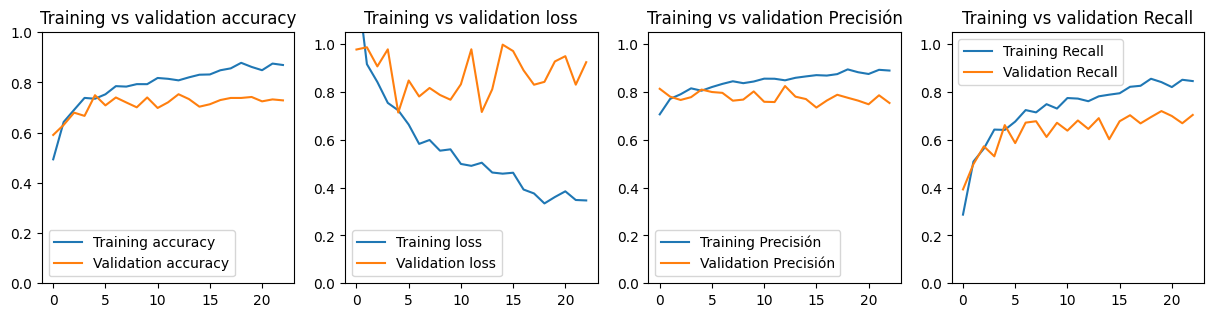

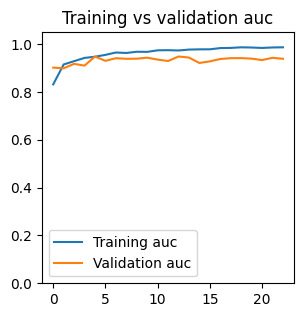

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 22s 575ms/step


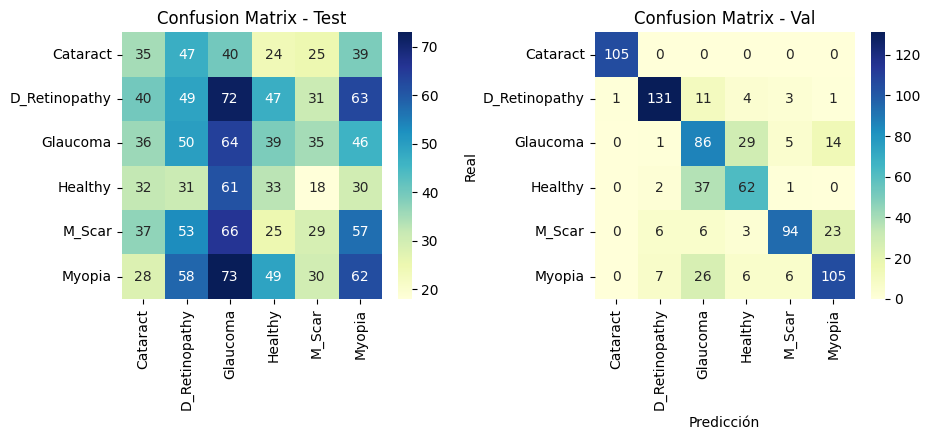

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       210
           1       0.17      0.16      0.17       302
           2       0.17      0.24      0.20       270
           3       0.15      0.16      0.16       205
           4       0.17      0.11      0.13       267
           5       0.21      0.21      0.21       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.89      0.87      0.88       151
           2       0.52      0.64      0.57       135
           3       0.60      0.61      0.60       102
           4       0.86      0.71      0.78       132
           5       0.73      0.70      0.72       150

    accuracy                           0.75       775
   macro avg       0.77

## Modelo 3

In [ ]:
base_model3 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model3.layers:
    layer.trainable = False


model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(2048, activation = 'relu'))
model3.add(Dense(4096, activation = 'sigmoid'))
model3.add(Dense(2048, activation = 'relu'))
model3.add(Dense(6, activation='softmax'))
model3.summary()

model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history3 = model3.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_22 (Dense)            (None, 4096)              8392704   
                                                                 
 dense_23 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_24 (Dense)            (None, 6)                 12294     
                                                      

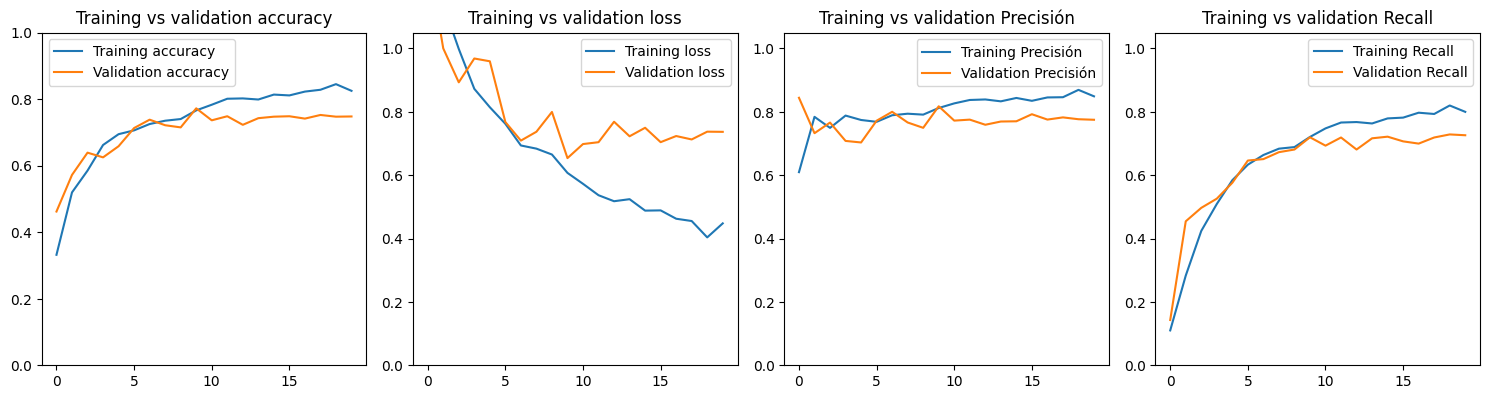

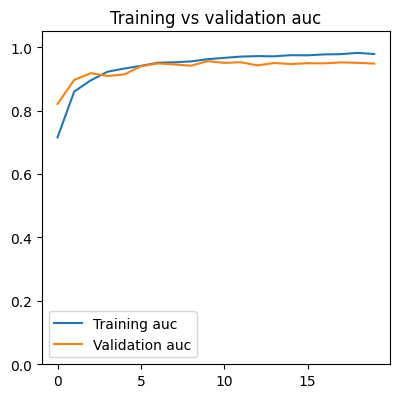

In [ ]:
graph(history3)

39/39 [==============================] - 19s 506ms/step


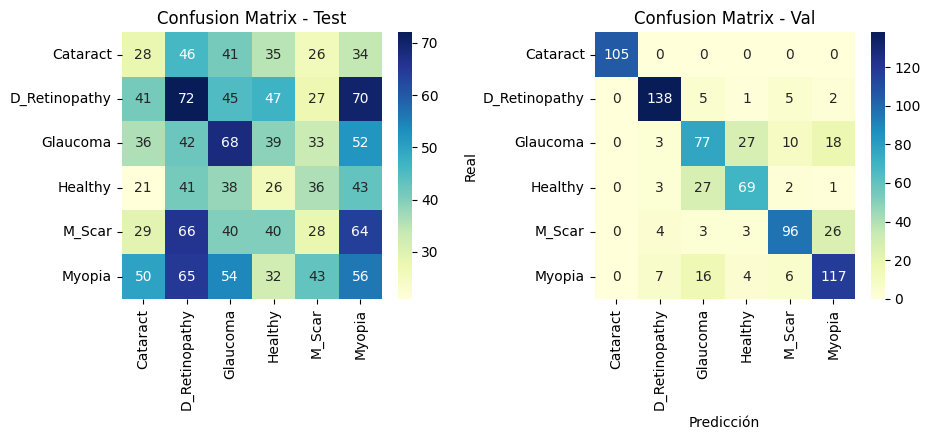

In [ ]:
y_pred3_test = model3.predict(test_generator)
y_pred3_val = model3.predict(validation_generator)
cf_matrix(y_pred3_test, test_generator.classes, y_pred3_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model3, y_pred3_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model3, y_pred3_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.13      0.13       210
           1       0.22      0.24      0.23       302
           2       0.24      0.25      0.24       270
           3       0.12      0.13      0.12       205
           4       0.15      0.10      0.12       267
           5       0.18      0.19      0.18       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.89      0.91      0.90       151
           2       0.60      0.57      0.59       135
           3       0.66      0.68      0.67       102
           4       0.81      0.73      0.76       132
           5       0.71      0.78      0.75       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 7

In [ ]:
base_model7 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model7.layers:
    layer.trainable = False


model7 = Sequential()
model7.add(base_model7)
model7.add(GlobalAveragePooling2D())
model7.add(Dense(2048, activation = 'relu'))
model7.add(Dropout(0.5))
model7.add(Dense(4096, activation = 'sigmoid'))
model7.add(Dropout(0.5))
model7.add(Dense(2048, activation = 'relu'))
model7.add(Dropout(0.25))
model7.add(Dense(6, activation='softmax'))
model7.summary()

model7.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history7 = model7.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0 

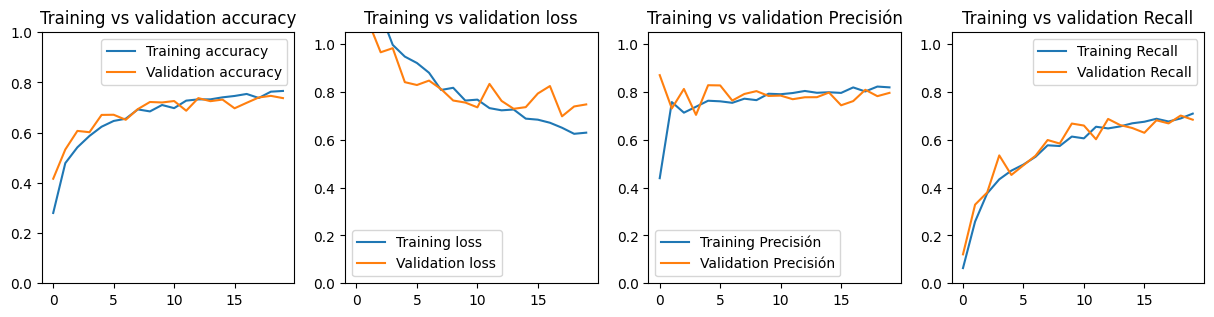

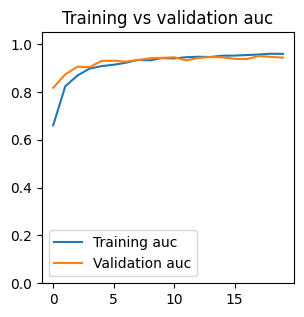

In [ ]:
graph(history7)

39/39 [==============================] - 23s 602ms/step


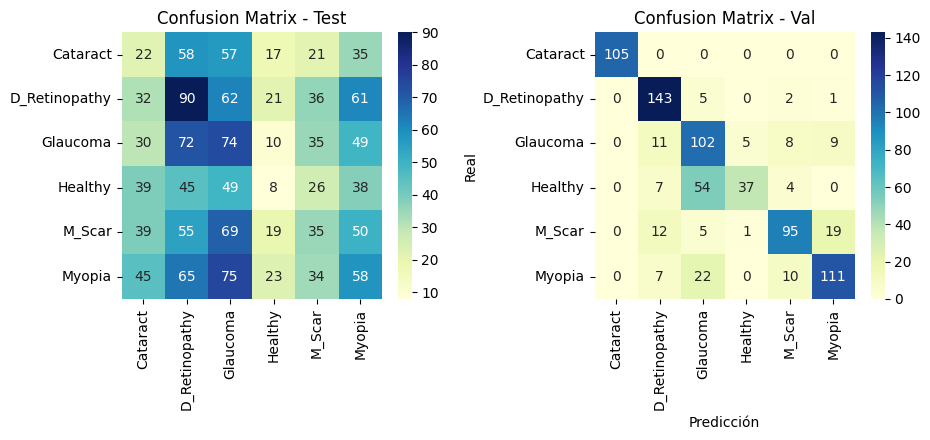

In [ ]:
y_pred7_test = model7.predict(test_generator)
y_pred7_val = model7.predict(validation_generator)
cf_matrix(y_pred7_test, test_generator.classes, y_pred7_val, validation_generator.classes)

In [ ]:
current_lr = model7.optimizer.learning_rate.numpy()
print("Current Learning Rate:", current_lr)

Current Learning Rate: 0.001


In [ ]:
reporte = calcular_metricas_por_clase(model7, y_pred7_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model7, y_pred7_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.10      0.11       210
           1       0.23      0.30      0.26       302
           2       0.19      0.27      0.23       270
           3       0.08      0.04      0.05       205
           4       0.19      0.13      0.15       267
           5       0.20      0.19      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.79      0.95      0.86       151
           2       0.54      0.76      0.63       135
           3       0.86      0.36      0.51       102
           4       0.80      0.72      0.76       132
           5       0.79      0.74      0.77       150

    accuracy                           0.77       775
   macro avg       0.80

## Modelo 8

In [ ]:
from tensorflow.keras.layers import GlobalMaxPool2D

base_model8 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model8.layers:
    layer.trainable = False


model8 = Sequential()
model8.add(base_model8)
model8.add(GlobalMaxPool2D())
model8.add(Dense(2048, activation = 'relu'))
model8.add(Dropout(0.5))
model8.add(Dense(4096, activation = 'sigmoid'))
model8.add(Dropout(0.5))
model8.add(Dense(2048, activation = 'relu'))
model8.add(Dropout(0.25))
model8.add(Dense(6, activation='softmax'))
model8.summary()

model8.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history8 = model8.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                      

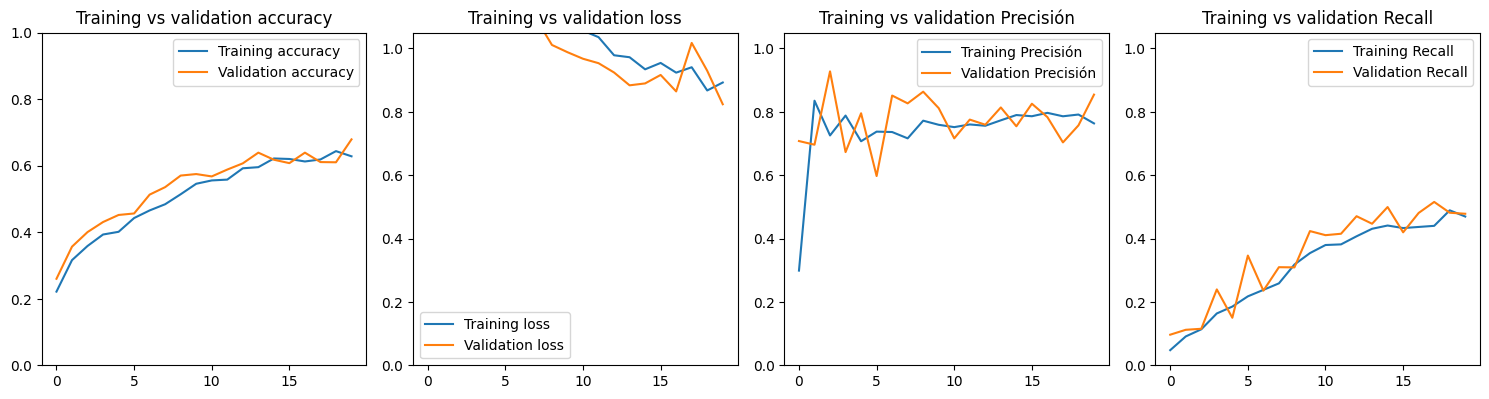

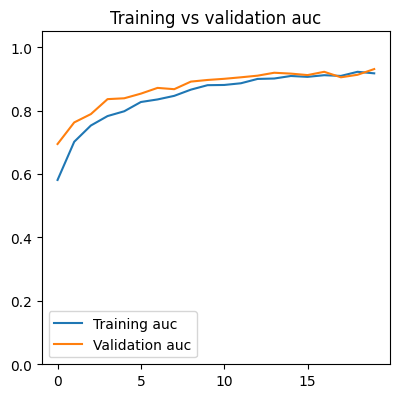

In [ ]:
graph(history8)

39/39 [==============================] - 21s 550ms/step


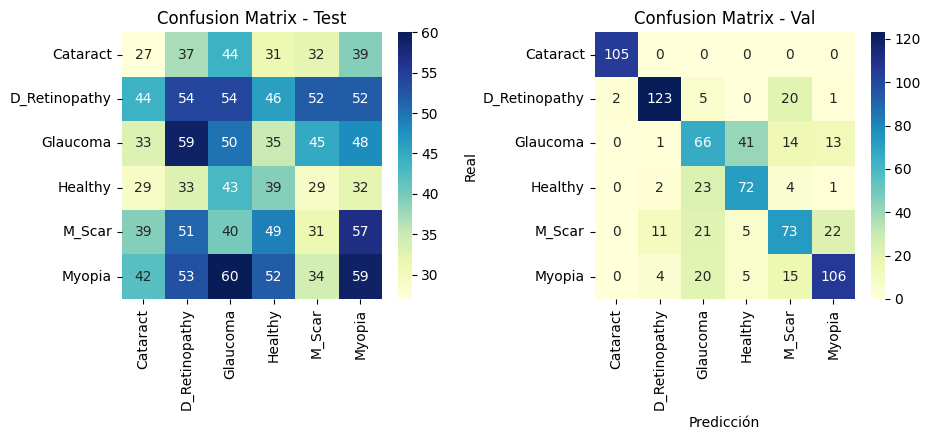

In [ ]:
y_pred8_test = model8.predict(test_generator)
y_pred8_val = model8.predict(validation_generator)
cf_matrix(y_pred8_test, test_generator.classes, y_pred8_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model8, y_pred8_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model8, y_pred8_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.18      0.18       302
           2       0.17      0.19      0.18       270
           3       0.15      0.19      0.17       205
           4       0.14      0.12      0.13       267
           5       0.21      0.20      0.20       300

    accuracy                           0.17      1554
   macro avg       0.16      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.87      0.81      0.84       151
           2       0.49      0.49      0.49       135
           3       0.59      0.71      0.64       102
           4       0.58      0.55      0.57       132
           5       0.74      0.71      0.72       150

    accuracy                           0.70       775
   macro avg       0.71

## Modelo 9

In [ ]:
base_model9 = tf.keras.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model9.layers:
    layer.trainable = False


model9 = Sequential()
model9.add(base_model9)
model9.add(GlobalAveragePooling2D())
model9.add(Dense(2048, activation = 'relu'))
model9.add(Dense(4096, activation = 'sigmoid'))
model9.add(Dense(2048, activation = 'relu'))
model9.add(Dense(6, activation='softmax'))
model9.summary()

model9.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history9 = model9.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_9 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_10 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_11 (Dense)            (None, 6)                 

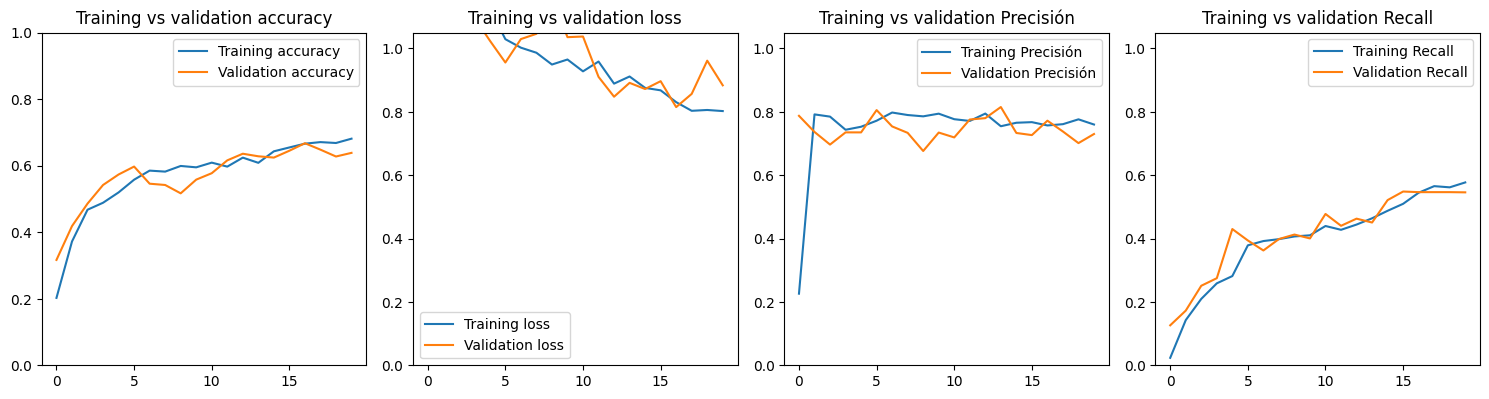

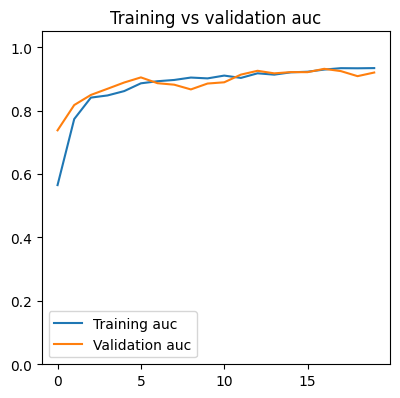

In [ ]:
graph(history9)

39/39 [==============================] - 26s 676ms/step


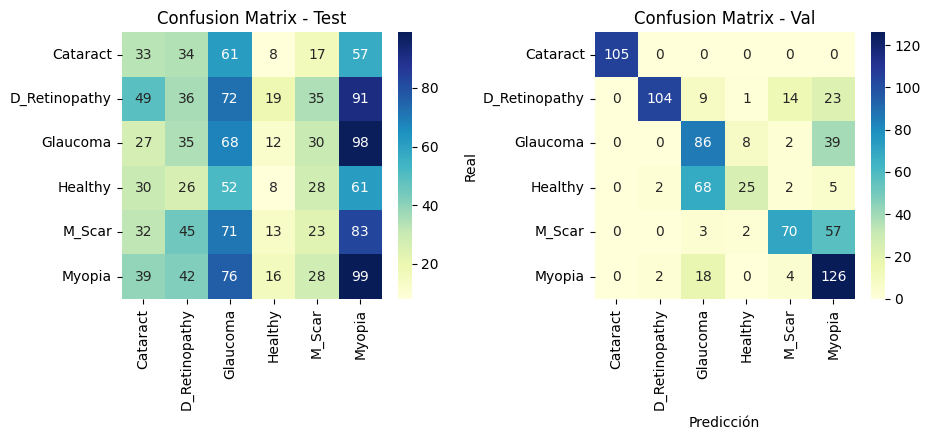

In [ ]:
y_pred9_test = model9.predict(test_generator)
y_pred9_val = model9.predict(validation_generator)
cf_matrix(y_pred9_test, test_generator.classes, y_pred9_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model9, y_pred9_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model9, y_pred9_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.17      0.12      0.14       302
           2       0.17      0.25      0.20       270
           3       0.11      0.04      0.06       205
           4       0.14      0.09      0.11       267
           5       0.20      0.33      0.25       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.16      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.96      0.69      0.80       151
           2       0.47      0.64      0.54       135
           3       0.69      0.25      0.36       102
           4       0.76      0.53      0.62       132
           5       0.50      0.84      0.63       150

    accuracy                           0.67       775
   macro avg       0.73

## Modelo 2

In [ ]:
base_model2 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model2.layers:
    layer.trainable = False


model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(6, activation='softmax'))
model2.summary()

model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history2 = model2.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                      

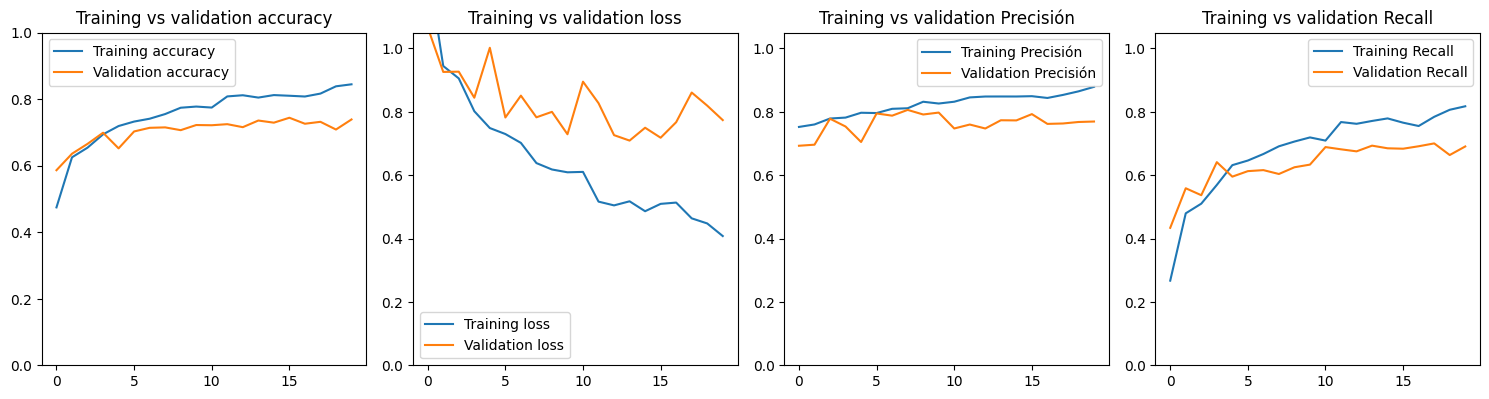

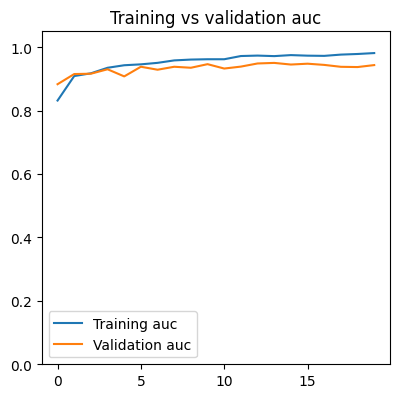

In [ ]:
graph(history2)

39/39 [==============================] - 21s 547ms/step


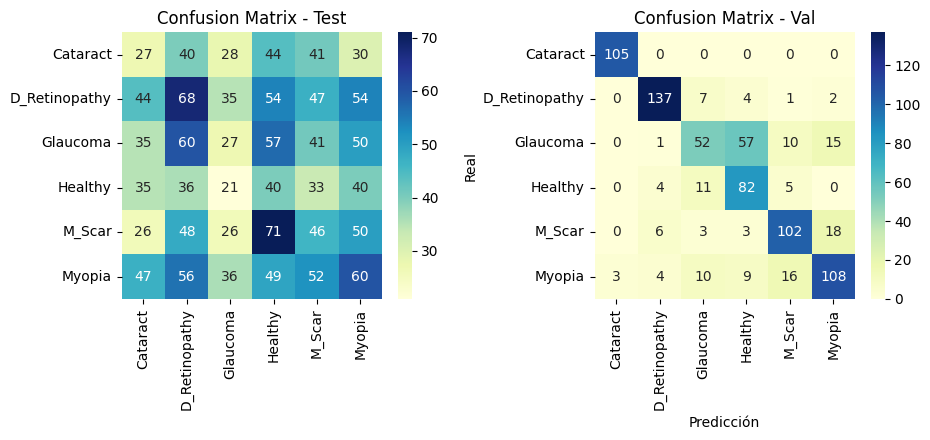

In [ ]:
y_pred2_test = model2.predict(test_generator)
y_pred2_val = model2.predict(validation_generator)
cf_matrix(y_pred2_test, test_generator.classes, y_pred2_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model2, y_pred2_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model2, y_pred2_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.22      0.23      0.22       302
           2       0.16      0.10      0.12       270
           3       0.13      0.20      0.15       205
           4       0.18      0.17      0.17       267
           5       0.21      0.20      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.90      0.91      0.90       151
           2       0.63      0.39      0.48       135
           3       0.53      0.80      0.64       102
           4       0.76      0.77      0.77       132
           5       0.76      0.72      0.74       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 20


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

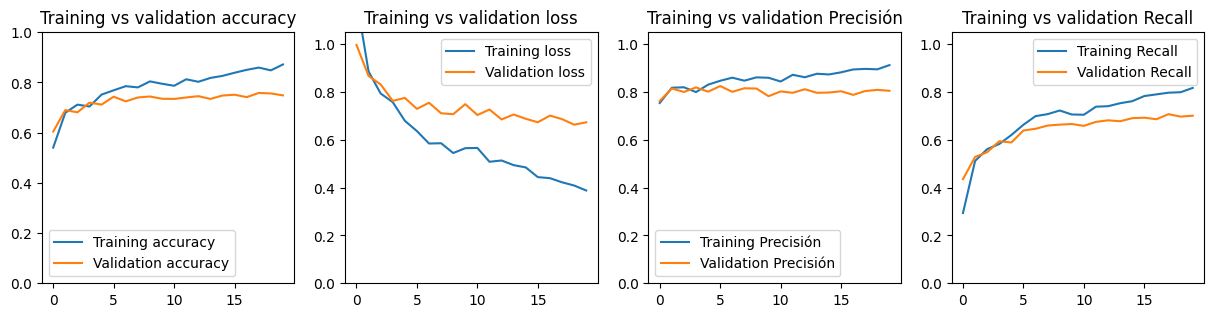

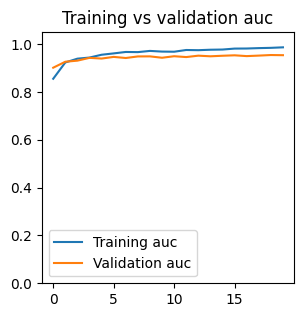

In [ ]:
graph(history_dense)

39/39 [==============================] - 23s 592ms/step


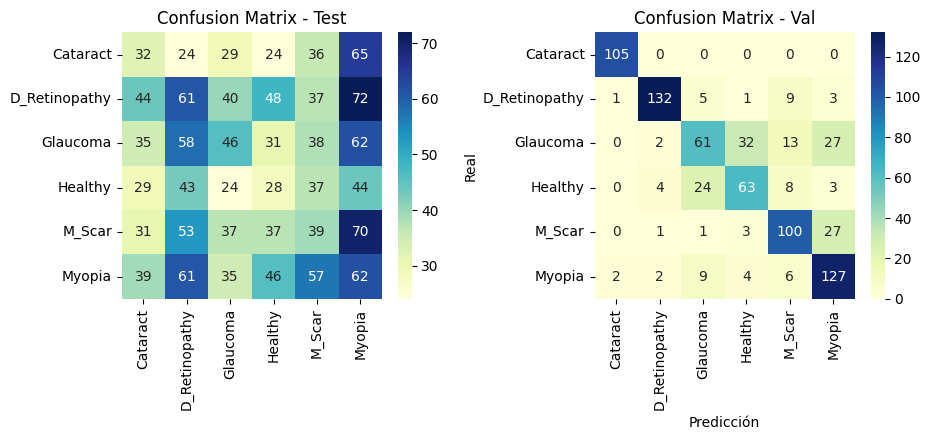

In [ ]:
y_pred_test = model.predict(test_generator)
y_pred_val = model.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.20      0.20      0.20       302
           2       0.22      0.17      0.19       270
           3       0.13      0.14      0.13       205
           4       0.16      0.15      0.15       267
           5       0.17      0.21      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.94      0.87      0.90       151
           2       0.61      0.45      0.52       135
           3       0.61      0.62      0.61       102
           4       0.74      0.76      0.75       132
           5       0.68      0.85      0.75       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 19

In [ ]:

# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/25
150/150 [==============================] - 156s 850ms/step - loss: 1.5018 - accuracy: 0.3867 - precision: 0.6890 - recall: 0.1167 - auc: 0.7458 - val_loss: 1.1289 - val_accuracy: 0.5444 - val_precision: 0.7442 - val_recall: 0.3108 - val_auc: 0.8705
Epoch 2/25
150/150 [==============================] - 164s 1s/step - loss: 1.1744 - accuracy: 0.5244 - precision: 0.7052 - recall: 0.3182 - auc: 0.8563 - val_loss: 0.9791 - val_accuracy: 0.6062 - val_precision: 0.7144 - val_recall: 0.4427 - val_auc: 0.9034
Epoch 3/25
150/150 [==============================] - 123s 819ms/step - loss: 1.0606 - accuracy: 0.5819 - precision: 0.7192 - recall: 0.4118 - auc: 0.8850 - val_loss: 0.9231 - val_accuracy: 0.6390 - val_precision: 0.7475 - val_recall: 0.4801 - val_auc: 0.9150
Epoch 4/25
150/150 [==============================] - 122s 815ms/step - loss: 0.9618 - accuracy: 0.6176 - precision: 0.7412 - recall: 0.4689 - auc: 0.9057 - v

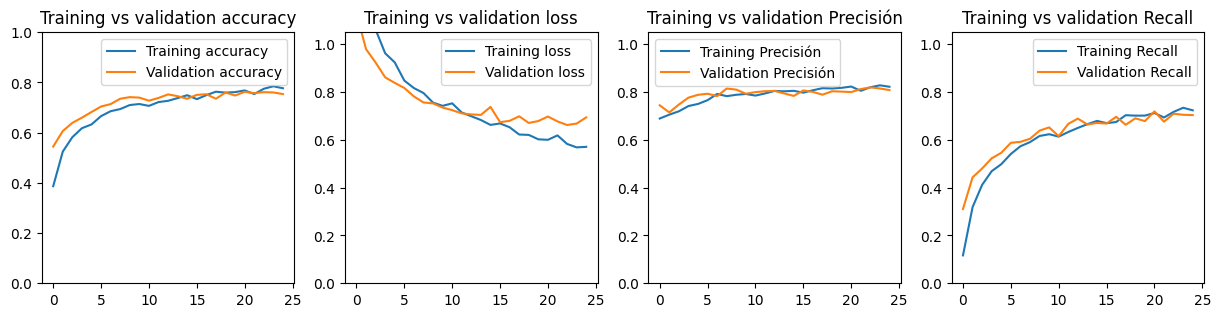

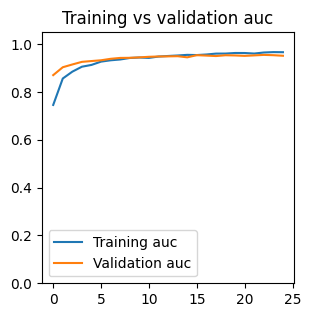

In [ ]:
graph(history19)

39/39 [==============================] - 25s 648ms/step


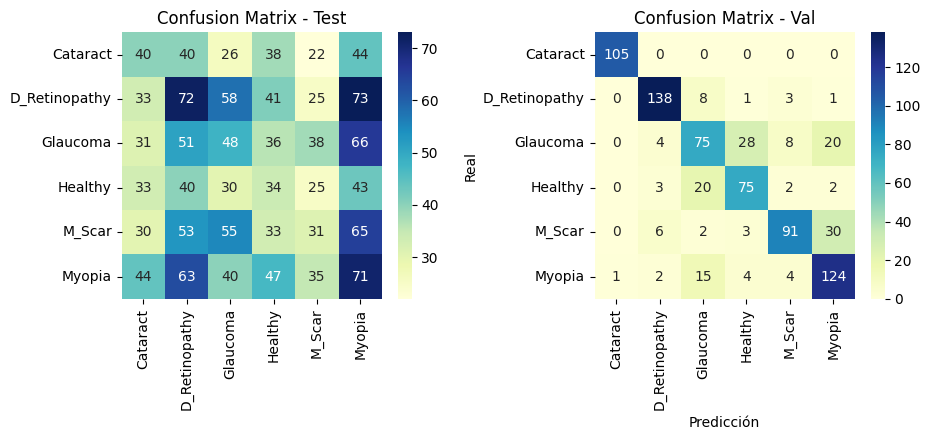

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.19      0.19      0.19       210
           1       0.23      0.24      0.23       302
           2       0.19      0.18      0.18       270
           3       0.15      0.17      0.16       205
           4       0.18      0.12      0.14       267
           5       0.20      0.24      0.21       300

    accuracy                           0.19      1554
   macro avg       0.19      0.19      0.19      1554
weighted avg       0.19      0.19      0.19      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.90      0.91      0.91       151
           2       0.62      0.56      0.59       135
           3       0.68      0.74      0.70       102
           4       0.84      0.69      0.76       132
           5       0.70      0.83      0.76       150

    accuracy                           0.78       775
   macro avg       0.79

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 135s 496ms/step - loss: 0.3832 - accuracy: 0.8514 - precision: 0.8829 - recall: 0.8117 - auc: 0.9855
Evaluar con Validación:
78/78 [==============================] - 39s 498ms/step - loss: 0.6987 - accuracy: 0.7574 - precision: 0.7905 - recall: 0.7162 - auc: 0.9516
Evaluar con Prueba:
39/39 [==============================] - 20s 506ms/step - loss: 0.5961 - accuracy: 0.7729 - precision: 0.8124 - recall: 0.7265 - auc: 0.9633


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 141s 517ms/step - loss: 0.2965 - accuracy: 0.8811 - precision: 0.9011 - recall: 0.8636 - auc: 0.9904
Evaluar con Validación:
78/78 [==============================] - 40s 508ms/step - loss: 0.7949 - accuracy: 0.7510 - precision: 0.7747 - recall: 0.7259 - auc: 0.9481
Evaluar con Prueba:
39/39 [==============================] - 20s 515ms/step - loss: 0.6497 - accuracy: 0.7781 - precision: 0.8003 - recall: 0.7548 - auc: 0.9583


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 133s 489ms/step - loss: 0.2736 - accuracy: 0.8929 - precision: 0.9004 - recall: 0.8884 - auc: 0.9910
Evaluar con Validación:
78/78 [==============================] - 38s 489ms/step - loss: 1.2761 - accuracy: 0.7040 - precision: 0.7147 - recall: 0.6931 - auc: 0.9135
Evaluar con Prueba:
39/39 [==============================] - 19s 488ms/step - loss: 0.9801 - accuracy: 0.7265 - precision: 0.7291 - recall: 0.7187 - auc: 0.9382


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 136s 501ms/step - loss: 0.1460 - accuracy: 0.9429 - precision: 0.9454 - recall: 0.9407 - auc: 0.9973
Evaluar con Validación:
78/78 [==============================] - 37s 476ms/step - loss: 0.9972 - accuracy: 0.7362 - precision: 0.7423 - recall: 0.7246 - auc: 0.9336
Evaluar con Prueba:
39/39 [==============================] - 18s 469ms/step - loss: 0.8892 - accuracy: 0.7355 - precision: 0.7477 - recall: 0.7303 - auc: 0.9472


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 127s 465ms/step - loss: 0.2120 - accuracy: 0.9135 - precision: 0.9199 - recall: 0.9052 - auc: 0.9949
Evaluar con Validación:
78/78 [==============================] - 38s 485ms/step - loss: 0.9845 - accuracy: 0.7194 - precision: 0.7401 - recall: 0.7072 - auc: 0.9364
Evaluar con Prueba:
39/39 [==============================] - 18s 464ms/step - loss: 0.7812 - accuracy: 0.7484 - precision: 0.7560 - recall: 0.7316 - auc: 0.9535


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 146s 536ms/step - loss: 0.2841 - accuracy: 0.8886 - precision: 0.9030 - recall: 0.8686 - auc: 0.9911
Evaluar con Validación:
78/78 [==============================] - 40s 506ms/step - loss: 0.9245 - accuracy: 0.7284 - precision: 0.7540 - recall: 0.7040 - auc: 0.9389
Evaluar con Prueba:
39/39 [==============================] - 20s 519ms/step - loss: 0.7510 - accuracy: 0.7523 - precision: 0.7750 - recall: 0.7200 - auc: 0.9514


In [ ]:
evaluar_modelo(model3)

Evaluar con Entrenamiento:
272/272 [==============================] - 154s 565ms/step - loss: 0.3564 - accuracy: 0.8636 - precision: 0.8848 - recall: 0.8356 - auc: 0.9866
Evaluar con Validación:
78/78 [==============================] - 39s 503ms/step - loss: 0.7366 - accuracy: 0.7477 - precision: 0.7747 - recall: 0.7259 - auc: 0.9485
Evaluar con Prueba:
39/39 [==============================] - 20s 522ms/step - loss: 0.6161 - accuracy: 0.7768 - precision: 0.7892 - recall: 0.7535 - auc: 0.9623


In [ ]:
evaluar_modelo(model7)

Evaluar con Entrenamiento:
272/272 [==============================] - 150s 551ms/step - loss: 0.5587 - accuracy: 0.7763 - precision: 0.8346 - recall: 0.7095 - auc: 0.9682
Evaluar con Validación:
78/78 [==============================] - 42s 536ms/step - loss: 0.7480 - accuracy: 0.7375 - precision: 0.7963 - recall: 0.6840 - auc: 0.9437
Evaluar con Prueba:
39/39 [==============================] - 21s 545ms/step - loss: 0.6378 - accuracy: 0.7652 - precision: 0.8079 - recall: 0.7110 - auc: 0.9585


In [ ]:
evaluar_modelo(model8)

Evaluar con Entrenamiento:
272/272 [==============================] - 148s 543ms/step - loss: 0.7563 - accuracy: 0.7058 - precision: 0.8829 - recall: 0.4943 - auc: 0.9436
Evaluar con Validación:
78/78 [==============================] - 44s 558ms/step - loss: 0.8237 - accuracy: 0.6789 - precision: 0.8540 - recall: 0.4781 - auc: 0.9312
Evaluar con Prueba:
39/39 [==============================] - 22s 577ms/step - loss: 0.7717 - accuracy: 0.7032 - precision: 0.8632 - recall: 0.4968 - auc: 0.9420


In [ ]:
evaluar_modelo(model9)

Evaluar con Entrenamiento:
272/272 [==============================] - 154s 566ms/step - loss: 0.8170 - accuracy: 0.6642 - precision: 0.7484 - recall: 0.5701 - auc: 0.9321
Evaluar con Validación:
78/78 [==============================] - 45s 573ms/step - loss: 0.8834 - accuracy: 0.6384 - precision: 0.7298 - recall: 0.5457 - auc: 0.9203
Evaluar con Prueba:
39/39 [==============================] - 23s 583ms/step - loss: 0.7641 - accuracy: 0.6658 - precision: 0.7409 - recall: 0.5794 - auc: 0.9403


In [ ]:
evaluar_modelo(model2)

Evaluar con Entrenamiento:
272/272 [==============================] - 154s 566ms/step - loss: 0.4064 - accuracy: 0.8448 - precision: 0.8764 - recall: 0.8080 - auc: 0.9830
Evaluar con Validación:
78/78 [==============================] - 44s 560ms/step - loss: 0.7737 - accuracy: 0.7387 - precision: 0.7692 - recall: 0.6905 - auc: 0.9437
Evaluar con Prueba:
39/39 [==============================] - 22s 566ms/step - loss: 0.6781 - accuracy: 0.7561 - precision: 0.7994 - recall: 0.7200 - auc: 0.9556


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 145s 533ms/step - loss: 0.4321 - accuracy: 0.8397 - precision: 0.8823 - recall: 0.7835 - auc: 0.9823
Evaluar con Validación:
78/78 [==============================] - 42s 532ms/step - loss: 0.6937 - accuracy: 0.7535 - precision: 0.8078 - recall: 0.7033 - auc: 0.9514
Evaluar con Prueba:
39/39 [==============================] - 21s 547ms/step - loss: 0.5855 - accuracy: 0.7845 - precision: 0.8195 - recall: 0.7381 - auc: 0.9648


In [ ]:
evaluar_modelo(model) # Modelo 20

Evaluar con Entrenamiento:
272/272 [==============================] - 144s 529ms/step - loss: 0.3893 - accuracy: 0.8662 - precision: 0.9064 - recall: 0.8113 - auc: 0.9863
Evaluar con Validación:
78/78 [==============================] - 42s 536ms/step - loss: 0.6731 - accuracy: 0.7484 - precision: 0.8049 - recall: 0.7008 - auc: 0.9538
Evaluar con Prueba:
39/39 [==============================] - 20s 515ms/step - loss: 0.6091 - accuracy: 0.7587 - precision: 0.8146 - recall: 0.7032 - auc: 0.9619
